# CREATE BASIC GRIDS

This code is made for calculate the flow accumulation and flow direction grid files. To use it you will need a DEM file and install pysheds library.

In this code, Iowa high resolution files will be created as a example.

Author: Vanessa Robledo (vrobledodelgado@uiowa.edu) 

In [1]:
!pip install pysheds


In [8]:
import pysheds
from pysheds.grid import Grid
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
import gdal
import shutil
import os

"""
Para usar este codigo, me toca primero calcular el FLowACC y flow dir del dem completo de AFRICA,
o recortarlo con un cuadrado y ya luego si usar las librerias y por ultimo pasar los resultados por el 
otro codigo que los cortaria para ghana y los dejaria en la version que se necesitan.

"""

'\nPara usar este codigo, me toca primero calcular el FLowACC y flow dir del dem completo de AFRICA,\no recortarlo con un cuadrado y ya luego si usar las librerias y por ultimo pasar los resultados por el \notro codigo que los cortaria para ghana y los dejaria en la version que se necesitan.\n\n'

In [7]:
#Define the path we you locate the Data
path_data = '/Users/vrobledodelgado/Documents/GitHub/FFWestAfrica/IOWA_example/'

### Download DEM and clip it using coords

In [ ]:
# get the 90m DEM for North Amercia
!wget https://data.hydrosheds.org/file/hydrosheds-v1-con/na_con_3s.zip
!unzip na_con_3s.zip -d na_con_3s
shutil.move('na_con_3s', path_data)
os.remove('na_con_3s.zip')

--2025-06-02 11:51:35--  https://data.hydrosheds.org/file/hydrosheds-v1-con/na_con_3s.zip
Resolving data.hydrosheds.org (data.hydrosheds.org)... 172.67.158.28, 104.21.14.61
Connecting to data.hydrosheds.org (data.hydrosheds.org)|172.67.158.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2705138845 (2.5G) [application/zip]
Saving to: ‘na_con_3s.zip’

na_con_3s.zip       100%[===================>]   2.52G  28.4MB/s    in 91s     

2025-06-02 11:53:06 (28.5 MB/s) - ‘na_con_3s.zip’ saved [2705138845/2705138845]

Archive:  na_con_3s.zip
 extracting: na_con_3s/na_con_3s.tif  
 extracting: na_con_3s/HydroSHEDS_TechDoc_v1_4.pdf  


'/Users/vrobledodelgado/Documents/GitHub/FFWestAfrica/IOWA_example/na_con_3s'

Process the DEM using gdal: usign coordinates lat lon to clip the rasterfile and keep only the region of interest 


In [ ]:
#Iowa coordinates
xmin = -99
xmax = -88.5
ymin = 39
ymax = 44.5

def ClipRaster(gridFile, xmin, ymin, xmax, ymax, gridOutName):
    # Open the input raster file
    rawGridIn = gdal.Open(gridFile, gdal.GA_ReadOnly)
    if rawGridIn is None:
        raise Exception(f"Failed to open the input raster file: {gridFile}")

    # Clip the raster to the specified extent
    clipped_ds = gdal.Warp(
        gridOutName,
        rawGridIn,
        format='GTiff',
        outputBounds=(xmin, ymin, xmax, ymax),
        dstNodata=-9999.0,  # Set a temporary NoData value
        outputType=gdal.GDT_Float32  # Ensure output is in Float32
    )

    if clipped_ds is None:
        raise Exception("Failed to clip the raster.")

    # Close the datasets
    rawGridIn = None
    clipped_ds = None
    # dst_ds = None

In [11]:
gridFile = path_data+'na_con_3s/na_con_3s.tif'
gridOutName = path_data+'hydro_DEM_iowa.tif'
# Call the function to clip the raster
ClipRaster(gridFile, xmin, ymin, xmax, ymax, gridOutName)

## Using Pysteps to create FAC and FDIR 

In [12]:
#read dem 
grid = Grid.from_raster(gridOutName)
dem = grid.read_raster(gridOutName)
dem[dem == -9999] = np.nan

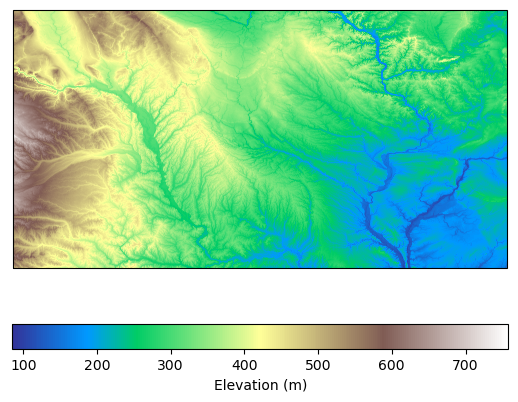

In [13]:
#visualize it 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.imshow(dem, extent=grid.extent, cmap="terrain")
plt.colorbar(label="Elevation (m)", orientation="horizontal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

In [ ]:
#conditioning elevation data
# In this case we do not have to do this process because  hydrosheds at 90m is already conditioned 
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
conditioned_dem = grid.resolve_flats(dem)
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.imshow(conditioned_dem, extent=grid.extent, cmap="terrain")
plt.colorbar(label="Elevation (m)", orientation="horizontal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

### Computing D8 flow directions

In [33]:
#computing flow direction
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
flowdir = grid.flowdir(dem, dirmap=dirmap)
flowdir

Raster([[ -2,  16,   1, ...,   2,   1,  -1],
        [ 64,  32,   1, ...,   1,  -1,  -1],
        [ -1,  -1, 128, ...,  -1,  -1,  -1],
        ...,
        [128,   1,   2, ...,   4,   4,   8],
        [  1,   1,   1, ...,  -1,  -1,  16],
        [  1, 128,  64, ...,  -1,  -1,  16]])

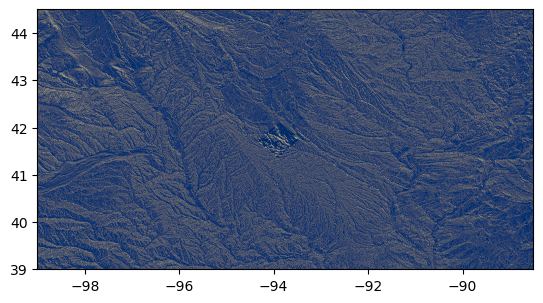

In [34]:
plt.imshow(flowdir, extent=grid.extent, cmap="cividis")

### Computing Flow accumulation

In [35]:
accumulation = grid.accumulation(flowdir)
accumulation

Raster([[4., 1., 1., ..., 1., 1., 2.],
        [1., 1., 1., ..., 1., 3., 1.],
        [1., 1., 1., ..., 6., 2., 1.],
        ...,
        [1., 1., 2., ..., 2., 2., 1.],
        [1., 2., 6., ..., 7., 5., 1.],
        [1., 2., 1., ..., 3., 2., 1.]])

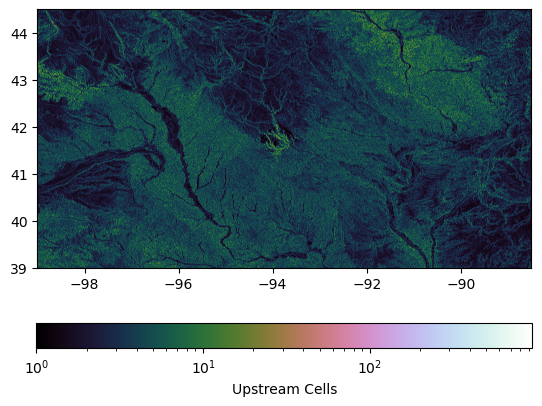

In [36]:
fig, ax = plt.subplots()
im = ax.imshow(
    acc,
    extent=grid.extent,
    cmap="cubehelix",
    norm=LogNorm(1, accumulation.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells", orientation="horizontal")

### Save flow direction and accumulation in EF5 format

In [57]:
def save_tif(raster_file, output_path):
    import rasterio
    data = np.array(raster_file.view()).astype('float32')    # call the method to get the array
    transform = raster_file.affine
    crs = 'EPSG:4326'
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype='float32',
        crs=crs,
        transform=transform,
        nodata=-9999.0
    ) as dst:
        dst.write(data, 1)

In [ ]:
# Save the flow direction and accumulation to raster files
output_acc = path_data + 'accumulation_iowa.tif'
output_fdir = path_data + 'flowdir_iowa.tif'

save_tif(accumulation, output_acc)
save_tif(flowdir, output_fdir)

